In [3]:
import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph
import torch
import math
%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


In [4]:
def f(x):
  return 5*x**2

def dydx(x):
  return 10*x

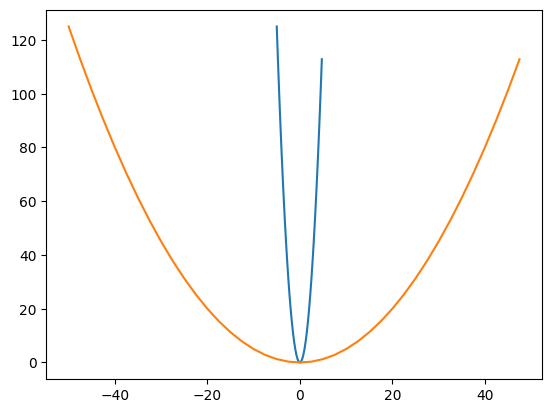

In [5]:

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
zs = dydx(xs)
plt.plot(xs, ys)
plt.plot(zs, ys)

# Derivative Basic

In [6]:
h = 0.01
x = -3
(f(x + h) - f(x))/h

-29.949999999999477

In [10]:
class Value:
  def __init__(self, val, _children = (), _op="", label = ""):
    self.data = val 
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None
  
  def __repr__(self):
    return f"Value(data = {self.data})"

  def __radd__(self, other):
    return self + other

  def __rmul__(self, other):
    return self * other

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")
    def backward():
      self.grad += out.grad * 1.0
      other.grad += out.grad * 1.0

    out._backward = backward
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), "exp")
    def backward():
      self.grad += out.data * out.grad
    out._backward = backward
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")
    def backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = backward
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def __truediv__(self, other):
    return self * other ** -1
  
  def __sub__(self, other):
    return self + (-1 * other)
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** other, (self,), f"**{other}")
    def backward():
      self.grad += other * (self.data)**(other - 1) * out.grad
    out._backward = backward
    return out


  def backward(self):
    topo = []
    visited = set()
    def build_topo(node):
      if node not in visited:
        visited.add(node)
        for child in node._prev:
          build_topo(child)
        topo.append(node)
      
    build_topo(self) 
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [9]:
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format="svg", graph_attr={'rankdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = '{ %s | data %.4f | grad %s }' % (n.label, n.data, n.grad), shape="record")
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  
  return dot

In [6]:

a = Value(10, label="a")
b = Value(-2, label="b")
c = Value(3, label="c")
d = Value(-5, label="d")


z = ((a * b) + c) * d

In [386]:
def F(a, b, c, d):
  x = a * b; x.label = "x"
  y = x + c; y.label = "y"
  z = y * d; z.label = "z"
  return z



In [390]:

h = 0.2 
d1 = F(a + Value(h), b, c, d )
d1

Value(data = 87.0)

In [391]:

d2 = F(a, b, c, d)
d2

Value(data = 85)

In [198]:
(d1.data - d2.data)/h


10.0

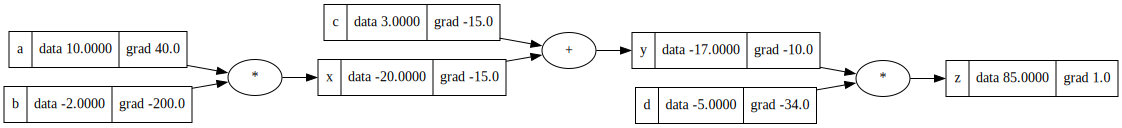

In [394]:
d2.backward()
draw_dot(d2)


In [200]:
# a = Value(10, label="a")
# b = Value(-2, label="b")
# c = Value(3, label="c")
# d = Value(-5, label="d")
x1 = torch.Tensor([10.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([-2.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([-5.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.293]).double(); b.requires_grad = True

q = F(x1, x2, w1, w2)
q

tensor([85.], dtype=torch.float64, grad_fn=<MulBackward0>)

In [209]:
x2.grad

tensor([-50.], dtype=torch.float64)

In [11]:
import math
import random
class Neuron:
    # Number of inputs this neuron has
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    # x has to be an array lol
    def __call__(self, x):
        # wx + b
        act = sum([wi * xi for (wi, xi) in zip(self.w, x)], self.b)
        out = act.tanh()
        return out 
    
    def parameters(self):
        return self.w + [self.b]

# A layer is nothing but a collection of neurons, with a fixed number of inputs and outputs
class Layer:
    # nin = Number of imputs PER neuron
    # nout = Total number of neurons in the layer
    # I wish karpathy helped make this more clear
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    # x again, has to be an array
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self): 
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:

    # nin = First layer number of inputs
    # arr_layer_out = output count of each layer
    def __init__(self, nin, arr_layer_out):
        arr = [nin] + arr_layer_out
        self.layers = [Layer(arr[i], arr[i + 1]) for i in range(len(arr) - 1)]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self): 
        return [p for layer in self.layers for p in layer.parameters()]



In [108]:
m = MLP(3, [4, 5, 1])
y = m([1, 2, 3])

In [109]:
xs = [
    [1.0, 2.0, 3.0, 4.0],
    [1.0, 1.0, 1.0, 1.0],
    [2.0, 3.0, 2.0, 2.0],
    [1.0, 1.0, 1.0, 2.0],
]
ys = [
    1.0,
    -1.0, 
    1.0,
    -1.0
]
m = MLP(4, [4, 3, 4, 1])



In [110]:
ypreds = [m(x) for x in xs]
loss = sum([(y_out - y_gt) ** 2 for (y_gt, y_out) in zip(ys, ypreds)])
loss

Value(data = 3.456294146981941)

In [119]:
for i in range(20):
  ypreds = [m(x) for x in xs]
  loss = sum([(y_out - y_gt) ** 2 for (y_gt, y_out) in zip(ys, ypreds)])

  for p in m.parameters():
      p.grad = 0

  loss.backward()
    
  for p in m.parameters():
      p.data += (-0.02 * p.grad)
  
  print(i, loss)
    

0 Value(data = 7.999710977895198)
1 Value(data = 7.999710152113362)
2 Value(data = 7.999709321607333)
3 Value(data = 7.999708486336486)
4 Value(data = 7.999707646259734)
5 Value(data = 7.999706801335512)
6 Value(data = 7.999705951521779)
7 Value(data = 7.9997050967760055)
8 Value(data = 7.999704237055164)
9 Value(data = 7.999703372315734)
10 Value(data = 7.999702502513676)
11 Value(data = 7.999701627604439)
12 Value(data = 7.999700747542947)
13 Value(data = 7.999699862283595)
14 Value(data = 7.999698971780233)
15 Value(data = 7.999698075986169)
16 Value(data = 7.999697174854155)
17 Value(data = 7.999696268336372)
18 Value(data = 7.999695356384437)
19 Value(data = 7.999694438949381)


In [40]:
ypreds


[Value(data = 3.5572773173532506e-05),
 Value(data = 9.107560131253662e-05),
 Value(data = 3.786767957070527e-05),
 Value(data = 5.481541230997539e-05)]